<a href="https://colab.research.google.com/github/kyunghyuncho/ammi-2019-nlp/blob/master/01-day-LM/ngram_lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Modeling

## Goal: compute a probabilty distribution over all possible sentences:


## $$p(W) = p(w_1, w_2, ..., w_T)$$

## This unsupervised learning problem can be framed as a sequence of supervised learning problems:

## $$p(W) = p(w_1) * p(w_2|w_1) * ... * p(w_T|w_1, ..., w_{T-1})$$

## If we have N sentences, each of them with T words / tokens, then we want to max:

## $$log p(W) = \sum_{n = 1}^N \sum_{i=1}^{T} log p(w_i | w_{<i})$$




# N-gram language model

## Goal: estimate the n-gram probabilities using counts of sequences of n consecutive words

## Given a sequence of words $w$, we want to compute

##  $$P(w_i|w_{i−1}, w_{i−2}, …, w_{i−n+1})$$

## Where $w_i$ is the i-th word of the sequence.

## $$P(w_i|w_{i−n+1}, ..., w_{i−2}, w_{i−1}) = \frac{p(w_{i−n+1}, ..., w_{i−2}, w_{i−1}, w_i)}{\sum_{w \in V} p(w_{i−n+1}, ..., w_{i−2}, w_{i−1}, w)}$$

## Key Idea: We can estimate the probabilities using counts of n-grams in our dataset 


# Let's see this in Practice

In [192]:
# TODOs
#: implement the neural LM with concat instead of summation -- so that you have a fixed input etc.
# make a separate
# create some slides with pictures maybe explaining the model visualizations -- line by line
# get google cloud working
# make it work on gpu
# show them kenlm and how to use to do different stuff with it
# use the same sentences to generation and testing etc.
# explain perplexity
# ngram, ff, rnn, rnn+attention
# do sentence generation
# do long sentences
# compare different n-grams -- 2,3,more

### Install if needed

TODO: should we install as needed and import as needed or all at once?

In [193]:
# # run if you dont have it installed
# !pip install more_itertools
# !pip install spacy# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager\
# !python -m spacy download en_core_web_sm

### Imports

In [194]:
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy
import itertools
from operator import itemgetter 
from glob import glob
from tqdm import tqdm_notebook, tqdm
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import string
import re
import more_itertools as mit  # not built-in package
import torch
import torchtext
import torchtext.data as data
from torchtext import vocab
from collections import Counter
import re
from torchtext.data import TabularDataset 

In [195]:
torch.manual_seed(1)


## Data Processing

In [196]:
import torch
import torchtext
import torchtext.data as data
from torchtext import vocab
from collections import Counter
import re
from torchtext.data import TabularDataset 

class AmazonReviewsDataset(TabularDataset):
    
    urls = [
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_CDs_and_Vinyl_5.json.gz',
           'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Kindle_Store_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Health_and_Personal_Care_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Tools_and_Home_Improvement_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Beauty_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Office_Products_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Pet_Supplies_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Automotive_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Grocery_and_Gourmet_Food_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Patio_Lawn_and_Garden_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Baby_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz',
#             'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz',
        ]
    name='amazonreviews'
    dirname='processed'

In [197]:
# # download_done = AmazonReviewsDataset.download(root='data/', check=True)

# # if above does not work do this in stead in cd ammi-2019-nlp/data
# !wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz
# !gunzip reviews_Clothing_Shoes_and_Jewelry_5.json.gz


In [225]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

def tokenize(s):
    return RETOK.findall(s)

text_field = data.Field(sequential=True, tokenize=tokenize, include_lengths=True, use_vocab=True, lower=True, batch_first=True)

In [199]:
dataset = AmazonReviewsDataset(path='/home/roberta/ammi-2019-nlp/data/reviews_Clothing_Shoes_and_Jewelry_5.json', format='json', fields={'reviewText': ('reviewText', text_field), 'summary': ('summary', text_field)})


In [200]:
# lets check it
# lets use fstrings btw
print(f'Number of samples : {len(dataset.examples)}')

for ex in dataset.examples:
    print(f'Review: \n {ex.reviewText} \n\n Summary: \n {ex.summary}')
    break

Number of samples : 278677
Review: 
 ['this', 'is', 'a', 'great', 'tutu', 'and', 'at', 'a', 'really', 'great', 'price', '.', 'it', 'doesn', "'", 't', 'look', 'cheap', 'at', 'all', '.', 'i', "'", 'm', 'so', 'glad', 'i', 'looked', 'on', 'amazon', 'and', 'found', 'such', 'an', 'affordable', 'tutu', 'that', 'isn', "'", 't', 'made', 'poorly', '.', 'a', '+', '+'] 

 Summary: 
 ['great', 'tutu', '-', 'not', 'cheaply', 'made']


In [201]:
# convert the dataset to a list of strings
# each string represents a review
all_reviews = []
for ex in dataset.examples:
    all_reviews.append(ex.reviewText)
len(all_reviews)

278677

In [202]:
all_reviews[0]

['this',
 'is',
 'a',
 'great',
 'tutu',
 'and',
 'at',
 'a',
 'really',
 'great',
 'price',
 '.',
 'it',
 'doesn',
 "'",
 't',
 'look',
 'cheap',
 'at',
 'all',
 '.',
 'i',
 "'",
 'm',
 'so',
 'glad',
 'i',
 'looked',
 'on',
 'amazon',
 'and',
 'found',
 'such',
 'an',
 'affordable',
 'tutu',
 'that',
 'isn',
 "'",
 't',
 'made',
 'poorly',
 '.',
 'a',
 '+',
 '+']

In [203]:

_tqdm = tqdm_notebook  # prolly you need jupyter widget for this, change for tqdm for simple tqdm

NUM_SENTENCES = len(all_reviews)
NUM_SENTENCES_TRAIN = int(0.8*NUM_SENTENCES)
NUM_SENTENCES_TEST = int(0.1*NUM_SENTENCES)
NUM_SENTENCES_VALID = NUM_SENTENCES - NUM_SENTENCES_TRAIN - NUM_SENTENCES_TEST

train_reviews = all_reviews[:NUM_SENTENCES_TRAIN]
test_reviews = all_reviews[NUM_SENTENCES_TRAIN:NUM_SENTENCES_TRAIN+NUM_SENTENCES_TEST]
valid_reviews = all_reviews[NUM_SENTENCES_TRAIN+NUM_SENTENCES_TEST:NUM_SENTENCES_TRAIN+NUM_SENTENCES_TEST+NUM_SENTENCES_VALID]


In [204]:
type(train_reviews), len(train_reviews), type(train_reviews[0]), type(train_reviews[0][0]), train_reviews[0][11], train_reviews[0]#, test_reviews[0], valid_reviews[0]


(list,
 222941,
 list,
 str,
 '.',
 ['this',
  'is',
  'a',
  'great',
  'tutu',
  'and',
  'at',
  'a',
  'really',
  'great',
  'price',
  '.',
  'it',
  'doesn',
  "'",
  't',
  'look',
  'cheap',
  'at',
  'all',
  '.',
  'i',
  "'",
  'm',
  'so',
  'glad',
  'i',
  'looked',
  'on',
  'amazon',
  'and',
  'found',
  'such',
  'an',
  'affordable',
  'tutu',
  'that',
  'isn',
  "'",
  't',
  'made',
  'poorly',
  '.',
  'a',
  '+',
  '+'])

In [205]:
# Create .txt files with the reviews

with open('../data/amazon_reviews_clothing_train.txt', 'w') as f:
    for review in train_reviews:
        for token in review:
            f.write("%s " % token) 
        f.write("\n")
        
with open('../data/amazon_reviews_clothing_test.txt', 'w') as f:
    for review in test_reviews:
        for token in review:
            f.write("%s " % token) 
        f.write("\n")
        
with open('../data/amazon_reviews_clothing_valid.txt', 'w') as f:
    for review in valid_reviews:
        for token in review:
            f.write("%s " % token) 
        f.write("\n")

### Load Data from .txt Files

In [267]:
# Read data from .txt files and create lists of reviews

train_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_train.txt', 'r') as f:
    train_data = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
# for review in reviews:
#     train_data.append(review.split())
    
test_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_test.txt', 'r') as f:
    test_data = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
# for review in reviews:
#     test_data.append(review.split())
    
valid_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_valid.txt', 'r') as f:
    valid_data = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
# for review in reviews:
#     valid_data.append(review.split())


In [268]:

type(train_data), len(train_data), \
type(train_data[0]), len(train_data[0]), \
type(train_data[0][0]), len(train_data[0][0])




(list, 222919, str, 184, str, 1)

In [269]:
train_data[0], train_data[0][0]


("this is a great tutu and at a really great price . it doesn ' t look cheap at all . i ' m so glad i looked on amazon and found such an affordable tutu that isn ' t made poorly . a + + ",
 't')

### Process the Data

In [270]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')               
punctuations = string.punctuation
# punctuations = '"#$%&\'()*+,-/:;<=>@[\\]^_`{|}~' 
TAG_RE = re.compile(r'<[^>]+>') # get rid off HTML tags from the data

def remove_tags(text):
    return TAG_RE.sub('', text)

def lower_case(parsed):
    return [token.text.lower() for token in parsed] #and (token.is_stop is False)]

def remove_punc(parsed):
    return [token.text for token in parsed if (token.text not in punctuations)]

def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations)] #and (token.is_stop is False)]

def tokenize_dataset(dataset):
   # tokenize each sentence -- each tokenized sentence will be an element in token_dataset
    token_dataset = []
    # tokenize all words -- each token will be an item in all_tokens (in the order given by the list of sentences)
    all_tokens = []     # all the tokens -- 

    for sample in _tqdm(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
#         tokens = lower_case_remove_punc(sample)
        tokens = lower_case(sample)       # make words lower case
#         tokens = remove_punct(tokens)     # remove punctuation
        token_dataset.append(tokens)    
        all_tokens += tokens
        
    return token_dataset, all_tokens

In [271]:
punctuations, punctuations[0], \
type(punctuations), len(punctuations), type(punctuations[0]), 

('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', '!', str, 32, str)

In [272]:
TAG_RE

re.compile(r'<[^>]+>', re.UNICODE)

In [273]:
# TODO: for now only work with small subset of the data -- switch to all data later
train_data = train_data[:80]
test_data = test_data[:10]
valid_data = valid_data[:10]

In [274]:
type(train_data), type(train_data[0]), type(train_data[0][0])

(list, str, str)

In [275]:
# Tokenize the Datasets
# TODO: this takes a really long time !! why?
train_data_tokenized, all_tokens_train = tokenize_dataset(train_data)
test_data_tokenized, all_tokens_test = tokenize_dataset(test_data)
valid_data_tokenized, all_tokens_valid = tokenize_dataset(valid_data)


Let's look at the tokenized data!

In [276]:
# Number of All Tokens
len(all_tokens_train), all_tokens_train[0], \
len(train_data_tokenized), train_data_tokenized[0]

(14771,
 'this',
 80,
 ['this',
  'is',
  'a',
  'great',
  'tutu',
  'and',
  'at',
  'a',
  'really',
  'great',
  'price',
  '.',
  'it',
  'doesn',
  "'",
  't',
  'look',
  'cheap',
  'at',
  'all',
  '.',
  'i',
  "'",
  'm',
  'so',
  'glad',
  'i',
  'looked',
  'on',
  'amazon',
  'and',
  'found',
  'such',
  'an',
  'affordable',
  'tutu',
  'that',
  'isn',
  "'",
  't',
  'made',
  'poorly',
  '.',
  'a',
  '+',
  '+'])

#### Build the Vocabulary 


In [286]:
# Build a vocabulary using all the tokens found in train data (90% of most common ones)
voc = list(set(all_tokens_train))
print('Word vocabulary size: {} words'.format(len(voc)))        


Word vocabulary size: 2091 words


### CORPUS ANALYSIS (Train + Valid Data)

#### Number of Tokens in the Corpus Data


In [281]:
print("Number of All Tokens ", len(all_tokens_train))

Number of All Tokens  14771


In [283]:
print("Number of All UNIQUE Tokens ", len(voc))

Number of All UNIQUE Tokens  2091


#### Number of Sentences in the Train Data


In [285]:
print("Number of Sentences ", len(train_data_tokenized))

Number of Sentences  80


#### Count how often each sentence length occurs. Visualize this! 

#### Average sentence length

## N-grams

In [1106]:
n = 3 # trigrams

#### Change n to see how the results change
#### unigrams: n = 1; bigrams: n = 2; trigrams: n = 3;


#### Generate a list of words and their corresponding frequencies. Which are the 10 most frequent words?



### Function for padding the sentences with special markers sentence beginning and end, i.e. $<bos>$ and $<eos>$

In [1107]:
def pad_sentences(input_list, n):
    result_list = []
    for l in input_list:
        padded = ["<bos>" for i in range((n - 1))] + l +["<eos>" for i in range((n - 1))]
        result_list.append(padded)
    return result_list

In [1108]:
train_padded = pad_sentences(train_data_tokenized, n)
valid_padded = pad_sentences(valid_data_tokenized, n)
test_padded = pad_sentences(test_data_tokenized, n)

In [1111]:
# train_padded[:2]

### Function for finding all N-grams

In [1112]:
def find_ngrams(input_list, n):
    result_list = []
    for l in input_list:
        result_list.append(list(zip(*[l[i:] for i in range(n)])))
    return result_list

#### Convert the dataset to its corresponding n-gram version

In [1115]:
# train_ngram[:2]

### Function for Getting N-gram counts for already tokenized data

In [1116]:
def ngram_counts(data, n, frac_vocab=0.9):    
    all_train_tokens = list(mit.flatten(data))
    counted_tokens = Counter(all_train_tokens)
    max_vocab_size = int(frac_vocab * len(counted_tokens))

    vocab, count = zip(*counted_tokens.most_common(max_vocab_size))
    
    return vocab, count

In [1117]:
vocab_ngram, count_ngram = ngram_counts(train_ngram, n)


In [ ]:
train_ngram = find_ngrams(train_padded, n)
vocab_trigram, count_trigram = ngram_counts(train_ngram, n)
vocab_trigram, count_trigram = ngram_counts(train_ngram, n)

In [1121]:
# vocab_ngram[:3], count_ngram[:3]

### Function for Getting N-gram Dict

In [1122]:
def ngram_dict(vocab):
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(4, 4+len(vocab)))) 
    id2token = ['<pad>', '<unk>', '<bos>', '<eos>'] + id2token

    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    token2id['<bos>'] = BOS_IDX 
    token2id['<eos>'] = EOS_IDX

    return id2token, token2id

In [1123]:
id2token_ngram, token2id_ngram = ngram_dict(vocab_ngram)

In [1128]:
# id2token_ngram[:10], \
# token2id_ngram['<unk>'], token2id_ngram['<eos>'], token2id_ngram[('rosetta', 'stone')]

In [1129]:
random_token_id = random.randint(0, len(id2token_ngram) - 1)
random_token = id2token_ngram[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token_ngram[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id_ngram[random_token]))

Token id 11204 ; token ('or', 'two', 'before')
Token ('or', 'two', 'before'); token id 11204


In [1130]:
def _text2id(doc, token2id):
    return [token2id[t] if t in token2id else UNK_IDX for t in doc]

def _id2text(vec, id2token):
    return [id2token[i] for i in vec]
    

In [1131]:
def create_data_id(data, token2id):
    data_id = []
    for d in data:
        data_id.append(_text2id(d, token2id))
    return data_id

def create_data_id_merged(data, token2id):
    data_id_merged = []
    for d in data:
        data_id_merged.append((d, 0))
    return data_id_merged


In [1132]:
data_id = create_data_id(train_data_ngram, token2id_ngram)
data_id_merged = create_data_id_merged(data_id, token2id_ngram)

In [1133]:
# type(data_id), data_id[0]

In [1134]:
# type(data_id_merged), data_id_merged[0]

In [1135]:
# Function that combines all the aboce and goes from tokenized data to the ngram dataset
def create_id_dataset(data, n):
    padded_data = pad_sentences(data, n)
    ngram_data = find_ngrams(padded_data, n)
    
    vocab, count = ngram_counts(ngram_data, n)    
    id2token, token2id = ngram_dict(vocab)
    
    data_id = create_data_id(ngram_data, token2id)
    data_id_merged = create_data_id_merged(data_id, token2id)
    
    return data_id, data_id_merged

In [1136]:
all_data_id, all_data_id_merged = create_id_dataset(train_data_tokenized, n)

In [1137]:
# all_data_id[0], all_data_id_merged[0]


### Function for computing the probability of an n-gram

In [1150]:
vocab_ngram[:10], count_ngram[:10]

((('.', '<eos>', '<eos>'),
  ('it', "'", 's'),
  ('.', '.', '.'),
  ('i', "'", 'm'),
  ('<bos>', '<bos>', 'i'),
  ('don', "'", 't'),
  ('!', '<eos>', '<eos>'),
  ('i', "'", 've'),
  ('.', 'i', "'"),
  ('you', "'", 're')),
 (59, 40, 33, 26, 23, 23, 14, 14, 13, 13))

In [1139]:
def get_ngram_count(ngram, vocab, count):
    if ngram in vocab:
        ngram_idx = vocab.index(ngram)
        return count[ngram_idx] 
    else:
        return 0


In [1141]:
c = get_ngram_count(('.', 'i'), vocab_ngram, count_ngram)
c

# c = get_ngram_count(('baby', 'panda'), vocab_ngram, count_ngram)
# c

0

In [1154]:
c = get_ngram_count(('it', "'", 's'), vocab_ngram, count_ngram)
c


# c = get_ngram_count(('baby', 'panda', 'sweet'), vocab_ngram, count_ngram)
# c

40

### Function for computing the probability of a sentence

In [1177]:
def get_ngram_prob(ngram, vocab, count):
    c = get_ngram_count(ngram, vocab, count)
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
            print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    if all_counts > 0:
        return c / all_counts
    else:
        return 0

In [1178]:
p = get_ngram_prob(('rosetta', 'stone'), vocab_ngram, count_ngram)
p, 69/(69+2+2+1+1+1+1+1)

# p = get_ngram_prob(('i', 'am'), vocab_ngram, count_ngram)
# p

# p = get_ngram_prob(('it', "'", 's'), vocab_ngram, count_ngram)
# p

# p = get_ngram_prob(('i', "like", 'it'), vocab_ngram, count_ngram)
# p, 1/(2+1+1+1+1)

(0, 0.8846153846153846)

In [1246]:
def get_prob_sentence(sentence, vocab, count):
    padded_sentence = pad_sentences(sentence, n)  # needs a list
#     print(padded_sentence)
    ngram_sentence = find_ngrams(padded_sentence, n)[0] # only one element in list
#     print(ngram_sentence)
    prob = 1
    for ngram in ngram_sentence:
        prob_ngram = get_ngram_prob(ngram, vocab, count)
        print(ngram, prob_ngram)
        prob *= prob_ngram
    return prob

In [1247]:
sentence = [train_data_tokenized[0]]
# sentence = [['this', 'is', 'a', 'great', 'tutu']]
print(sentence)
ps = get_prob_sentence(sentence, vocab_ngram, count_ngram)
ps

[['this', 'is', 'a', 'great', 'tutu', 'and', 'at', 'a', 'really', 'great', 'price', '.', 'it', 'doesn', "'", 't', 'look', 'cheap', 'at', 'all', '.', 'i', "'", 'm', 'so', 'glad', 'i', 'looked', 'on', 'amazon', 'and', 'found', 'such', 'an', 'affordable', 'tutu', 'that', 'isn', "'", 't', 'made', 'poorly', '.', 'a', '+', '+']]
('<bos>', '<bos>', 'this') 0.0684931506849315
('<bos>', 'this', 'is') 0.5
('this', 'is', 'a') 0.45
('is', 'a', 'great') 0.16
('a', 'great', 'tutu') 0.09090909090909091
('great', 'tutu', 'and') 0.5
('tutu', 'and', 'at') 1.0
('and', 'at', 'a') 0.3333333333333333
('at', 'a', 'really') 0.16666666666666666
('a', 'really', 'great') 1.0
('really', 'great', 'price') 1.0
('great', 'price', '.') 1.0
('price', '.', 'it') 0.4
('.', 'it', 'doesn') 0.022222222222222223
('it', 'doesn', "'") 1.0
('doesn', "'", 't') 1.0
("'", 't', 'look') 0.016129032258064516
('t', 'look', 'cheap') 1.0
('look', 'cheap', 'at') 1.0
('cheap', 'at', 'all') 1.0
('at', 'all', '.') 0.42857142857142855
('all

4.0055998183675866e-17

In [1248]:
def get_prob_distr_ngram(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=False):
    pd = [0 for v in voc]
    for idx, token in enumerate(voc):
#         print("token: ", token)
#         print("prev ngram: ", prev_tokens)
#         print("both: ", tuple(list(prev_tokens) + [token]))
#         print("")
        token_ngram = tuple(list(prev_tokens) + [token])
        pd[idx] = get_ngram_prob(token_ngram, vocab_ngram, count_ngram)
        if pd[idx] > 0 and print_nonzero_probs:
            print(token_ngram, " ", pd[idx])
    return pd

In [1249]:
# prob distr for the word following prev_tokens (i.e. tutu) 
# over all the words in the vocabulary 

# prev_tokens = train_data_tokenized[0][4] #[0]
prev_tokens = vocab_ngram[3][1:] #[0]   # need frmo 1 on so that this is a correct prev token
print(prev_tokens)
pd = get_prob_distr_ngram(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=True)
sum(pd)#, pd

("'", 'm')
("'", 'm', 'finding')   0.04
("'", 'm', 'enrolled')   0.04
("'", 'm', 'one')   0.04
("'", 'm', 'fluent')   0.04
("'", 'm', 'very')   0.04
("'", 'm', 'enjoying')   0.04
("'", 'm', 'a')   0.04
("'", 'm', 'given')   0.04
("'", 'm', 'not')   0.32
("'", 'm', 'hearing')   0.04
("'", 'm', 'sure')   0.08
("'", 'm', 'most')   0.04
("'", 'm', 'happy')   0.04
("'", 'm', 'so')   0.08
("'", 'm', 'calling')   0.04
("'", 'm', 'more')   0.04


1.0

In [1256]:
def sample_from_pd(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=False):
    pd = get_prob_distr_ngram(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=print_nonzero_probs)
    idx_next_token = np.random.choice(len(voc), 1, p=pd)[0]
    return voc[idx_next_token]
    

In [1257]:
print(prev_tokens)
next_token = sample_from_pd(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=True)
next_token

("'", 'm')
("'", 'm', 'finding')   0.04
("'", 'm', 'enrolled')   0.04
("'", 'm', 'one')   0.04
("'", 'm', 'fluent')   0.04
("'", 'm', 'very')   0.04
("'", 'm', 'enjoying')   0.04
("'", 'm', 'a')   0.04
("'", 'm', 'given')   0.04
("'", 'm', 'not')   0.32
("'", 'm', 'hearing')   0.04
("'", 'm', 'sure')   0.08
("'", 'm', 'most')   0.04
("'", 'm', 'happy')   0.04
("'", 'm', 'so')   0.08
("'", 'm', 'calling')   0.04
("'", 'm', 'more')   0.04


'enjoying'

In [1268]:
def generate_sentence(num_tokens, vocab_ngram, count_ngram, voc, n):
    sentence = []
    prev_tokens = tuple(['<bos>'] * (n - 1))
#     print(prev_tokens)
    for i in range(num_tokens):
        next_token = sample_from_pd(prev_tokens, vocab_ngram, count_ngram, voc)
#         print(i, next_token)
#         print(i, prev_tokens[1:])
        prev_tokens = tuple(list(prev_tokens[1:]) + [next_token])
#         print(i, prev_tokens)
        sentence.append(next_token)
        print(' '.join(sentence))
    return ' '.join(sentence)

In [1269]:
num_tokens = 5
generated_sentence = generate_sentence(num_tokens, vocab_ngram, count_ngram, voc, n)
generated_sentence

# TODO: make this owkr for general ngram -- double check that it works

i
i bought
i bought this
i bought this for
i bought this for christmas


'i bought this for christmas'

## Add-One Smoothing

In [1277]:
def get_ngram_prob_add_one_smoothing(ngram, vocab, count):
    c = get_ngram_count(ngram, vocab, count) + 1
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
            print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    all_counts += len(voc)
    if all_counts > 0:
        return c / all_counts
    else:
        return 0

In [1346]:
# TODO: show examples
p = get_ngram_prob(('am', 'rosetta', 'stone'), vocab_ngram, count_ngram)
p


0

In [1347]:
p = get_ngram_prob_add_one_smoothing(('am', 'rosetta', 'stone'), vocab_ngram, count_ngram)
p


0.00047824007651841227

## Additive Smoothing

In [1322]:
def get_ngram_prob_addditive_smoothing(ngram, vocab, count, delta=0.5):
    c = get_ngram_count(ngram, vocab, count) + delta*1
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
            print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    all_counts += delta*len(voc)
    if all_counts > 0:
        return c / all_counts
    else:
        return 0

In [1345]:
p = get_ngram_prob_addditive_smoothing(('am', 'rosetta', 'stone'), vocab_ngram, count_ngram, delta=0.1)
p

0.0004782400765184122

### Linear Interpolation Smoothing

In [1342]:
def get_ngram_prob_interpolation_smoothing(ngram, vocab, count, prev_vocab, prev_count, alpha=0.5):
    c = get_ngram_count(ngram, vocab, count)
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
            print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    if all_counts > 0:
        prob_ngram = c / all_counts
    else:
        prob_ngram = 0
    
    prev_ngram = tuple(list(ngram[1:]))
    prev_c = get_ngram_count(prev_ngram, prev_vocab, prev_count)
    print(prev_c)
    prev_all_counts = 0
    for prev_t in prev_vocab:
        if prev_t[:-1] == prev_ngram[:-1]:
            print(prev_t, get_ngram_count(prev_t, prev_vocab, prev_count))
            prev_all_counts += get_ngram_count(prev_t, prev_vocab, prev_count)
    if prev_all_counts > 0:
        prob_prev_ngram = prev_c / prev_all_counts
    else:
        0
    return alpha*(prob_ngram) + (1-alpha)*prob_prev_ngram

In [1343]:
train_padded = pad_sentences(train_data_tokenized, 3)
train_trigram = find_ngrams(train_padded, 3)
vocab_trigram, count_trigram = ngram_counts(train_trigram, 3)


train_padded = pad_sentences(train_data_tokenized, 2)
train_bigram = find_ngrams(train_padded, 2)
vocab_bigram, count_bigram = ngram_counts(train_bigram, 2)

train_padded = pad_sentences(train_data_tokenized, 1)
train_unigram = find_ngrams(train_padded, 1)
vocab_unigram, count_unigram = ngram_counts(train_unigram, 1)


In [1344]:
p = get_ngram_prob_interpolation_smoothing(('am', 'rosetta', 'stone'), \
    vocab_trigram, count_trigram, vocab_bigram, count_bigram, alpha=0.5)
p

69
('rosetta', 'stone') 69
('rosetta', 'studio') 2
('rosetta', 'world') 2
('rosetta', ',') 1
('rosetta', 'very') 1
('rosetta', 'level') 1
('rosetta', 'program') 1
('rosetta', 'stones') 1


0.4423076923076923

## Smoothing: Linear Interpolation with Absolute Discounting

In [ ]:
def get_ngram_prob_interpolation_discounting_smoothing(ngram, vocab, count, prev_vocab, prev_count, alpha=0.5):
    
    return


## Bigram Probabilities

### $$p_{bi}(w|v) = max \large{ \frac{N(v, w) - b_{bi}}{N(v), 0}  + b_{bi} \frac{V - N_0(v, \cdot)}{N(v)} p_{uni}(w) \large}$$

### $$p_{uni}(w) = max \large{ \frac{N(w) - b_{uni}}{N, 0}  + b_{uni} \frac{V - N_0(\cdot)}{N} \frac{1}{V}}$$

### $$b_{bi} = \frac{N_1(\cdot, \cdot)}{N_1(\cdot, \cdot) + 2*N_2(\cdot, \cdot)}$$

### $$b_{uni} = \frac{N_1(\cdot)}{N_1(\cdot) + 2*N_2(\cdot)}$$


### $$N_r(\cdot) = \sum_{w: N(w) = r} 1$$

### $$N_r(\cdot, \cdot) = \sum_{v, w: N(v, w) = r} 1$$

### $$N_r(v, \cdot) = \sum_{w: N(v, w) = r} 1$$

### V is the number of words in the vocabulary

### $N_r(\cdot, \cdot)$ and $N_r(\cdot)$  are the count-counts for bigrams and unigrams respectively $


In [118]:
# TODO: Let's compute the bigram frequencies / probabilities



### Let's check that the probabilities sum up to one
### $$\sum_w p_{bi}(w|v) = \sum_w p_{uni}(w) = 1$$



In [119]:
# TODO: compute the sums

# show rank for each word in a sentence
# explain perplexity 

#### Let's look at some examples and see if they make sense

### Perplexity

### $PP = exp(-\frac{LL}{\sum_k(N_k + 1)})$

### $LL = \sum_{k=1}^{K} \sum_{n=1}^{N_k + 1} log p_{bi}(w_{k,n} | w_{k,n-1})$

#### Generate a complete list of trigrams occurring in the corpus. Which are the 10 most frequent trigrams?



#### Determine count statistics on the trigram frequencies, i.e. compute so-called count-counts (how many trigrams occur once, twice, : : :). Plot their distribution.

#### Generate a list of trigrams in the corpus using only the words in the vocabulary. 

#### Generate count statistics of the trigram frequencies for this modified corpus as well. What do you notice in comparison to the previous exercise?

#### Determine the out-of-vocabulary (OOV) rate, i.e. the percentage of running words in the corpus which are not covered by the vocabulary.

### Functions for Converting from Token to ID and back

In Part 1 you generated a trigram frequency list for a given vocabulary.
Determine the list of bigram frequencies from it by summing over the first word position:
N(v;w) = N(; v;w) =
X
u
N(u; v;w)
Analogously, recompute the frequencies of unigrams.
Now, extract bigrams/unigrams directly from the corpus using your implementation from part 1
and compare it to the recomputed versions. What do you notice? How could you x this problem
without changing the recomputation method?

#### Determine the list of bigram frequencies from it by summing over the first word position:

#### $ N(u, v, w) = \sum_u N(\cdot, v, w) $

#### Do the same for the unigrams. Do we get the same numbers as before?

## N-gram Probabilities

## $$P(w|w_{−n}, ..., w_{−2}, w_{−1}) \approx \frac{c(w_{−n}, ..., w_{−2}, w_{−1}, w)}{\sum_{w \in V} c(w_{−n}, ..., w_{−2}, w_{−1}, w)}$$


## Bigram Probabilities

## $$p(w_i | w_{i-1}) = \frac{c(w_{i-1}, w_i)}{\sum_{w_i} c(w_{i-1}, w_i)} $$


## Bigram LM
##  $$p(s) = \prod_{i = 1} ^ {N + 1} p(w_i | w_{i-1})$$

### Example
### Bigram LM: $$ p(i \; love \; this \; light) = p(i|\cdot) \; p(love|i)\;  p(this|love)\;  p(light|this) \\
\approx \frac{c(i, \cdot)}{\sum_w c(\cdot, \; w)} \; \frac{c(love, i)}{\sum_wc(i, \; w)}\;  \frac{c(this, love)}{\sum_wc(love, \;w)}\;  \frac{c(light, this)}{\sum_wc(this, \;w)}$$ 

### Trigram LM: $$ p(i \; love \; this  \;light) = p(i|\cdot, \cdot) \; p(love|\cdot, i) \; p(this|i, love)\;  p(light|love, this)$$ 



### Another Example -- where this approach usually fails

### Bigram LM: $$ p(john \; went \; to \; the \; moon) = p(john|\cdot) p(went|john) p(to|went) p(the|to) p(moon|the)$$ 

### Trigram LM: $$ pp(john \; went \; to \; the \; moon = p(john|\cdot, \cdot) p(went|\cdot, john) p(to|john, went) p(the|went, to) p(moon|to, the)$$ 



## Smoothing -- which ones to show? comparisons?

### Why do we need smoothing for n-gram language modeling?

### Sentece Probability

### Sentence Generation

# Neural Language Modeling

## Make a PyTorch Dataset out of our set of dicts

In [120]:
class ImdbDataset(Dataset):
    def __init__(self, data_list, max_inp_length=None, device='cpu'):
        """
        data_list is a list of tuples: (x,y) where x is a list of ids and y is a label
        """
        self.data = data_list
        self.max_len = max_inp_length
        self.data_tensors = []
        for (i, t) in tqdm_notebook(self.data):
            self.data_tensors.append((torch.LongTensor(i[:self.max_len]), torch.LongTensor([t])))
            #TODO: fix error regarding to(device)
#             self.data_tensors.append((torch.LongTensor(i[:self.max_len]).to(device), torch.LongTensor([t]).to(device)))
              
    def __getitem__(self, key):
        (inp, tgt) = self.data_tensors[key]
        
        return inp, tgt, len(inp)

    def __len__(self):
        return len(self.data)

def pad(tensor, length, dim=0, pad=0):
    """Pad tensor to a specific length.
    :param tensor: vector to pad
    :param length: new length
    :param dim: (default 0) dimension to pad
    :returns: padded tensor if the tensor is shorter than length
    """
    if tensor.size(dim) < length:
        return torch.cat(
            [tensor, tensor.new(*tensor.size()[:dim],
                                length - tensor.size(dim),
                                *tensor.size()[dim + 1:]).fill_(pad)],
            dim=dim)
    else:
        return tensor
    
def batchify(batch):
    maxlen = max(batch, key = itemgetter(2))[-1]
    batch_list = []
    target_list = []
    for b in batch:
        batch_list.append(pad(b[0], maxlen, dim=0, pad=PAD_IDX))
        target_list.append(b[1])
    input_batch = torch.stack(batch_list, 0)
    target_batch = torch.stack(target_list, 0)
    
    return input_batch, target_batch

In [121]:
train_dataset = ImdbDataset(train_data_id_merged, max_inp_length=None, device='cuda')
train_loader = DataLoader(train_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

valid_dataset = ImdbDataset(valid_data_id_merged, max_inp_length=None, device='cuda')
valid_loader = DataLoader(valid_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

## Model

In [122]:
class BagOfNGrams(nn.Module):
    def init_layers(self):
        for l in self.layers:
            if getattr(l, 'weight', None) is not None:
                torch.nn.init.xavier_uniform_(l.weight)
    
    def __init__(self, vocab_size, emb_dim=300, hidden_size=512, reduce='sum', nlayers=2, act='ReLU', nclasses=2, dropout=0.1, batch_norm=False):
        super(BagOfNGrams, self).__init__()
        self.emb_dim = emb_dim
        self.reduce = reduce
        self.nlayers = nlayers
        self.hidden_size = hidden_size
        self.nclasses = nclasses
        self.act = getattr(nn, act)
        self.embedding = nn.EmbeddingBag(num_embeddings=vocab_size, embedding_dim=emb_dim, mode=reduce)
        if batch_norm is True:
            self.batch_norm = nn.BatchNorm1d(self.emb_dim)
        self.layers = nn.ModuleList([nn.Linear(self.emb_dim, self.hidden_size)])
        self.layers.append(self.act())
#         self.layers.append(nn.Dropout(p=dropout))
        for i in range(self.nlayers-2):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.layers.append(self.act())
            self.layers.append(nn.Dropout(p=dropout))
        self.layers.append(nn.Linear(self.hidden_size, 1))
        self.init_layers()
    
    def forward(self, x):
        postemb = self.embedding(x)
        if hasattr(self, 'batch_norm'):
            x = self.batch_norm(postemb)
        else:
            x = postemb
        for l in self.layers:
            x = l(x)
        
        return x

model = BagOfNGrams(len(id2token), emb_dim=30, hidden_size=2048, act='Tanh', nlayers=1, reduce='mean', dropout=0.0, batch_norm=False)
model.cuda()

AttributeError: module 'torch.nn.init' has no attribute 'xavier_uniform_'

## Loss and Optimizer


In [123]:
learning_rate = 0.1
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, nesterov=True)
#optimizer = torch.optim.Adagrad(params=model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NameError: name 'model' is not defined

## Testing 

In [124]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, labels in loader:
        outputs = torch.sigmoid(model(data))
        predicted = (outputs > 0.5).long()
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

## Training

In [125]:
# TODO fix cuda issue!!! 
train_losses = []
num_epochs=20
for epoch in range(num_epochs):
    for i, (data, labels) in tqdm(enumerate(train_loader)): 
        data.cpu()
        labels.cpu()
        model.cpu()
        
        model.train()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.view(-1), labels.float().view(-1))
        loss.backward()
        print(loss.item())
        optimizer.step()
        train_losses.append(loss.item())

    if epoch % 1 == 0 and epoch > 0:
        val_acc = test_model(loader=valid_loader, model=model)
        print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss.item(), val_acc))

0it [00:00, ?it/s]


NameError: name 'model' is not defined

#### Visualize the Loss 

/home/roberta/miniconda3/lib/python3.6/site-packages/altair/utils/core.py:90: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  "Defaulting to nominal.".format(typ))


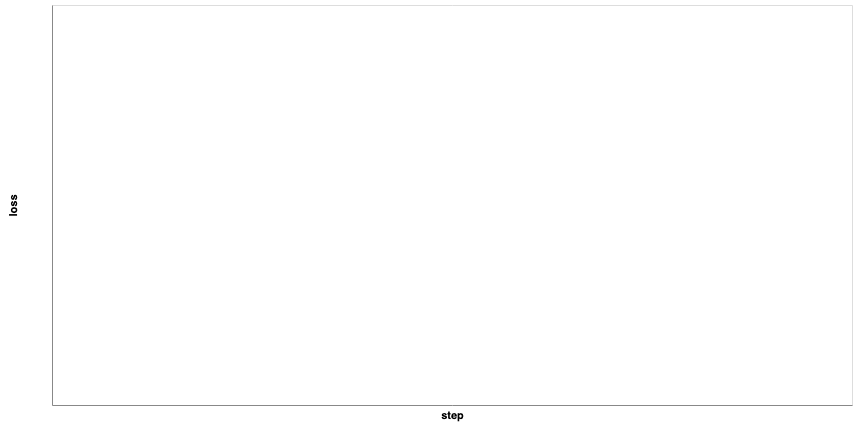

In [126]:
#!pip install altair
import altair as alt
import pandas

batch_loss = []
for i,l in enumerate(train_losses):
    batch_loss.append((i,l))

df = pandas.DataFrame(batch_loss, columns=['step', 'loss'])

alt.Chart(df).mark_line().encode(
    alt.X('step', scale=alt.Scale()),
    alt.Y('loss', scale=alt.Scale(type='log'))).properties(
        width=800,
        height=400
    )

## Analysis & Examples

## Compare N-gram LM to Neural LM

## Using FastText

## Using KenLM

In [16]:
out = vocab.FastText(language='en')

.vector_cache/wiki.en.vec:  19%|█▉        | 1.25G/6.60G [11:49<50:35, 1.76MB/s]


KeyboardInterrupt: 

In [ ]:
text_field.build_vocab(dataset, max_size=30000, vectors=out)

In [ ]:
# making a batch iterator
train_loader = data.BucketIterator(dataset=dataset, batch_size=4, sort_key=lambda x: len(x.reviewText), device=torch.device('cpu'), sort_within_batch=True, repeat=False)

In [ ]:
batch = next(iter(train_loader))
print(batch)

In [ ]:
def _vec2txt(vec):
    return [text_field.vocab.itos[t] for t in vec]

In [ ]:
print(batch.reviewText[0][0])
print(_vec2txt(batch.reviewText[0][0]))